In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report,
                           roc_curve, auc, roc_auc_score)
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline

print("Библиотеки успешно импортированы!")

Библиотеки успешно импортированы!


In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=';')

print("Информация о датасете:")
print(f"Размер: {df.shape}")
print(f"Колонки: {list(df.columns)}")
print("\nПервые 5 строк:")
df.head()

Информация о датасете:
Размер: (1599, 12)
Колонки: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

Первые 5 строк:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:
Распределение значений качества (quality):
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64


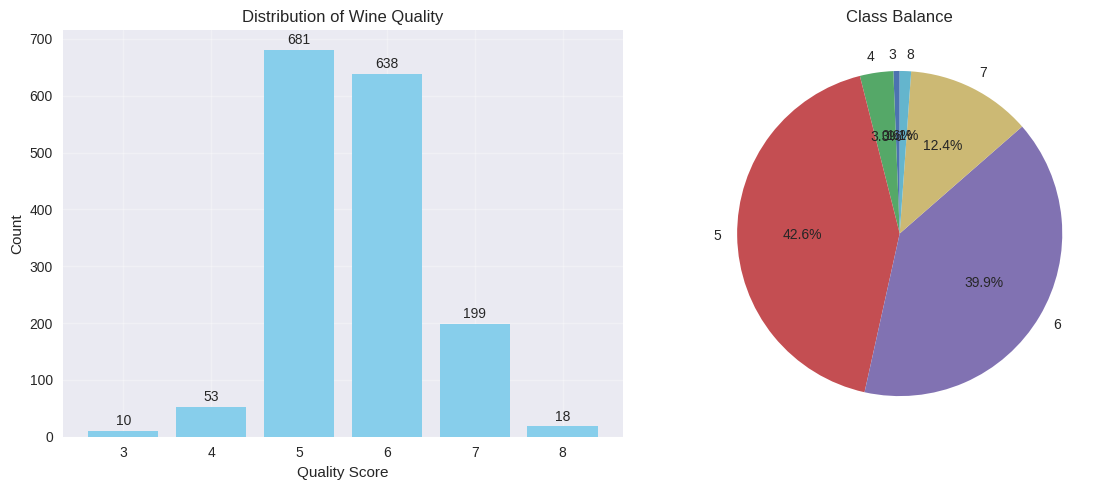


АНАЛИЗ СБАЛАНСИРОВАННОСТИ:
Качество 3: 10 образцов (0.6%)
Качество 4: 53 образцов (3.3%)
Качество 5: 681 образцов (42.6%)
Качество 6: 638 образцов (39.9%)
Качество 7: 199 образцов (12.4%)
Качество 8: 18 образцов (1.1%)

РЕКОМЕНДАЦИИ:
• Многоклассовая классификация (6 классов)
• Классы несбалансированы - требуется осторожность при оценке
• Рассмотреть объединение классов для балансировки


In [3]:
print("АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:")
print("="*50)

print("Распределение значений качества (quality):")
quality_distribution = df['quality'].value_counts().sort_index()
print(quality_distribution)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(quality_distribution.index, quality_distribution.values, color='skyblue')
plt.xlabel('Quality Score')
plt.ylabel('Count')
plt.title('Distribution of Wine Quality')
plt.grid(True, alpha=0.3)

for i, v in enumerate(quality_distribution.values):
    plt.text(quality_distribution.index[i], v + 10, str(v), ha='center')

plt.subplot(1, 2, 2)
total_samples = len(df)
balance_ratio = quality_distribution / total_samples
plt.pie(balance_ratio.values, labels=balance_ratio.index, autopct='%1.1f%%', startangle=90)
plt.title('Class Balance')

plt.tight_layout()
plt.show()

print(f"\nАНАЛИЗ СБАЛАНСИРОВАННОСТИ:")
for quality, count in quality_distribution.items():
    percentage = (count / total_samples) * 100
    print(f"Качество {quality}: {count} образцов ({percentage:.1f}%)")

print(f"\nРЕКОМЕНДАЦИИ:")
if len(quality_distribution) > 5:
    print("• Многоклассовая классификация (6 классов)")
    print("• Классы несбалансированы - требуется осторожность при оценке")
    print("• Рассмотреть объединение классов для балансировки")
else:
    print("• Подходит для классификации")

ПРЕОБРАЗОВАНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:
Бинарная классификация:
wine_quality_binary
0    1382
1     217
Name: count, dtype: int64
Соотношение: 1382:217

Многоклассовая классификация:
wine_quality_category
Medium    1319
High       217
Low         63
Name: count, dtype: int64


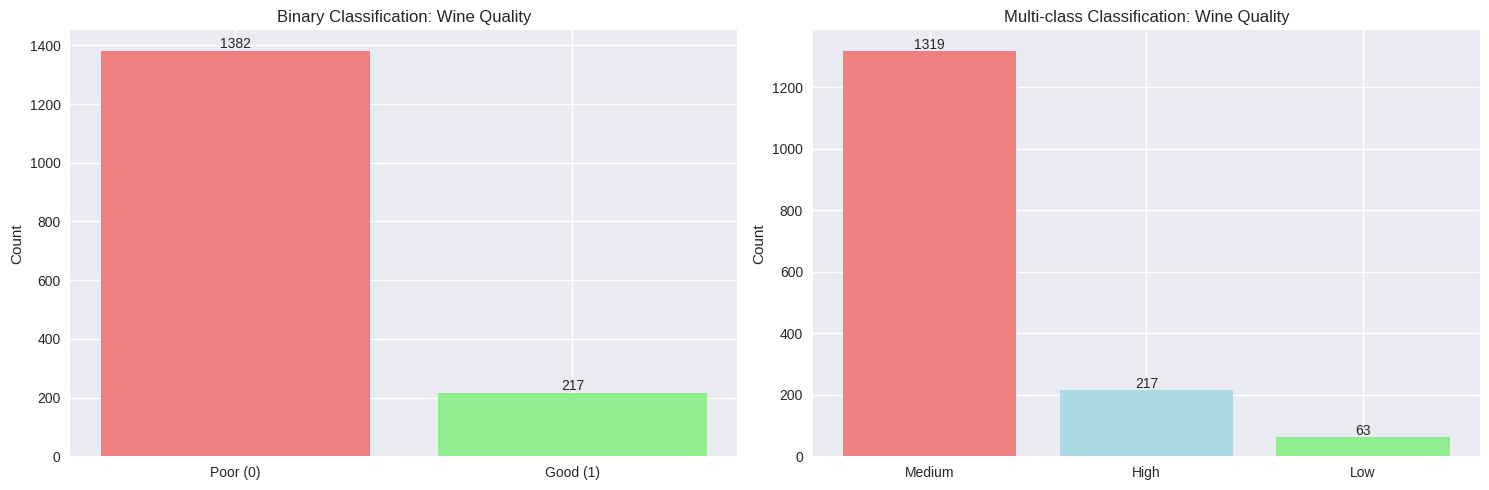


ВЫБОР ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:
• Для бинарной классификации: 'wine_quality_binary'
• Для многоклассовой классификации: 'wine_quality_category'


In [4]:
print("ПРЕОБРАЗОВАНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:")
print("="*50)

df['wine_quality_binary'] = (df['quality'] >= 7).astype(int)

def categorize_quality(quality):
    if quality <= 4:
        return 'Low'
    elif quality <= 6:
        return 'Medium'
    else:
        return 'High'

df['wine_quality_category'] = df['quality'].apply(categorize_quality)

print("Бинарная классификация:")
binary_dist = df['wine_quality_binary'].value_counts()
print(binary_dist)
print(f"Соотношение: {binary_dist[0]}:{binary_dist[1]}")

print("\nМногоклассовая классификация:")
category_dist = df['wine_quality_category'].value_counts()
print(category_dist)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

binary_counts = df['wine_quality_binary'].value_counts()
ax1.bar(['Poor (0)', 'Good (1)'], binary_counts.values, color=['lightcoral', 'lightgreen'])
ax1.set_title('Binary Classification: Wine Quality')
ax1.set_ylabel('Count')
for i, v in enumerate(binary_counts.values):
    ax1.text(i, v + 10, str(v), ha='center')

category_counts = df['wine_quality_category'].value_counts()
ax2.bar(category_counts.index, category_counts.values, color=['lightcoral', 'lightblue', 'lightgreen'])
ax2.set_title('Multi-class Classification: Wine Quality')
ax2.set_ylabel('Count')
for i, v in enumerate(category_counts.values):
    ax2.text(i, v + 5, str(v), ha='center')

plt.tight_layout()
plt.show()

print(f"\nВЫБОР ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:")
print("• Для бинарной классификации: 'wine_quality_binary'")
print("• Для многоклассовой классификации: 'wine_quality_category'")

In [5]:
print("ПОДГОТОВКА ПРИЗНАКОВ ДЛЯ КЛАССИФИКАЦИИ:")
print("="*50)

features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
           'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
           'pH', 'sulphates', 'alcohol']

X = df[features]
y_binary = df['wine_quality_binary']
y_multi = df['wine_quality_category']

print(f"Признаки: {len(features)}")
print(f"Бинарная классификация: {X.shape[0]} samples, {y_binary.nunique()} classes")
print(f"Многоклассовая классификация: {X.shape[0]} samples, {y_multi.nunique()} classes")

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X, y_binary, test_size=0.3, random_state=42, stratify=y_binary
)

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X, y_multi, test_size=0.3, random_state=42, stratify=y_multi
)

print(f"\nРАЗДЕЛЕНИЕ ДАННЫХ:")
print(f"Обучающая выборка (бинарная): {X_train_b.shape}")
print(f"Тестовая выборка (бинарная): {X_test_b.shape}")
print(f"Обучающая выборка (многоклассовая): {X_train_m.shape}")
print(f"Тестовая выборка (многоклассовая): {X_test_m.shape}")

scaler = StandardScaler()
X_train_b_scaled = scaler.fit_transform(X_train_b)
X_test_b_scaled = scaler.transform(X_test_b)
X_train_m_scaled = scaler.fit_transform(X_train_m)
X_test_m_scaled = scaler.transform(X_test_m)

print("\nМасштабирование признаков завершено!")

ПОДГОТОВКА ПРИЗНАКОВ ДЛЯ КЛАССИФИКАЦИИ:
Признаки: 11
Бинарная классификация: 1599 samples, 2 classes
Многоклассовая классификация: 1599 samples, 3 classes

РАЗДЕЛЕНИЕ ДАННЫХ:
Обучающая выборка (бинарная): (1119, 11)
Тестовая выборка (бинарная): (480, 11)
Обучающая выборка (многоклассовая): (1119, 11)
Тестовая выборка (многоклассовая): (480, 11)

Масштабирование признаков завершено!


K-NEAREST NEIGHBORS (KNN) - БИНАРНАЯ КЛАССИФИКАЦИЯ:


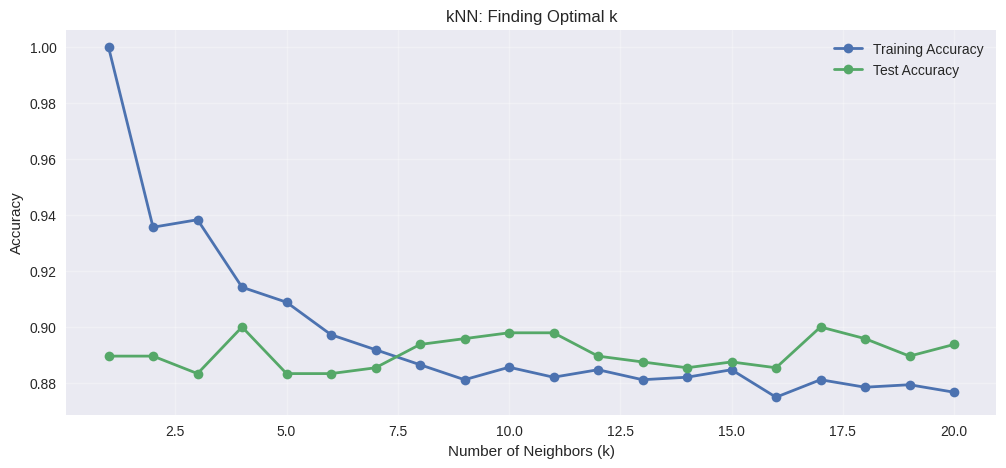

Оптимальное k: 4 (accuracy: 0.900)

KNN - БИНАРНАЯ КЛАССИФИКАЦИЯ - РЕЗУЛЬТАТЫ:
Accuracy: 0.900
Precision: 0.793
Recall: 0.354
F1-Score: 0.489


In [6]:
print("K-NEAREST NEIGHBORS (KNN) - БИНАРНАЯ КЛАССИФИКАЦИЯ:")
print("="*50)

k_range = range(1, 21)
train_scores = []
test_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_b_scaled, y_train_b)

    train_score = knn.score(X_train_b_scaled, y_train_b)
    test_score = knn.score(X_test_b_scaled, y_test_b)

    train_scores.append(train_score)
    test_scores.append(test_score)

plt.figure(figsize=(12, 5))
plt.plot(k_range, train_scores, 'o-', label='Training Accuracy', linewidth=2)
plt.plot(k_range, test_scores, 'o-', label='Test Accuracy', linewidth=2)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('kNN: Finding Optimal k')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

optimal_k = test_scores.index(max(test_scores)) + 1
print(f"Оптимальное k: {optimal_k} (accuracy: {max(test_scores):.3f})")

knn_binary = KNeighborsClassifier(n_neighbors=optimal_k)
knn_binary.fit(X_train_b_scaled, y_train_b)

y_pred_knn_b = knn_binary.predict(X_test_b_scaled)
y_pred_proba_knn_b = knn_binary.predict_proba(X_test_b_scaled)[:, 1]

print("\nKNN - БИНАРНАЯ КЛАССИФИКАЦИЯ - РЕЗУЛЬТАТЫ:")
print(f"Accuracy: {accuracy_score(y_test_b, y_pred_knn_b):.3f}")
print(f"Precision: {precision_score(y_test_b, y_pred_knn_b):.3f}")
print(f"Recall: {recall_score(y_test_b, y_pred_knn_b):.3f}")
print(f"F1-Score: {f1_score(y_test_b, y_pred_knn_b):.3f}")

K-NEAREST NEIGHBORS (KNN) - МНОГОКЛАССОВАЯ КЛАССИФИКАЦИЯ:


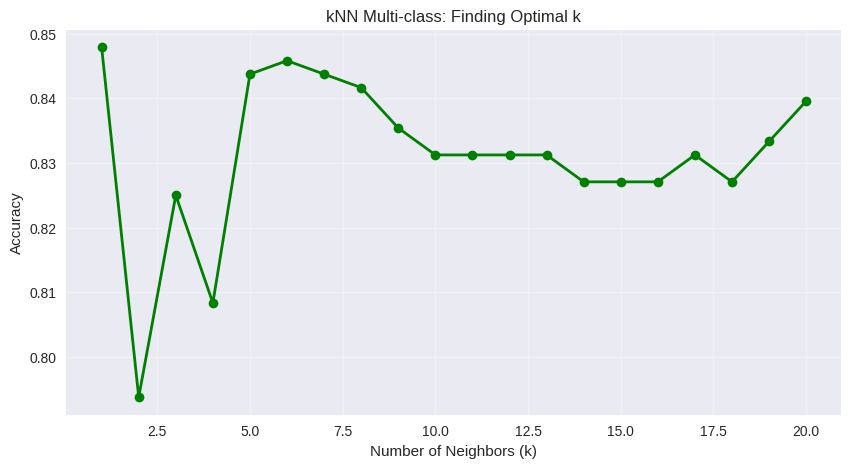

Оптимальное k: 1 (accuracy: 0.848)

KNN - МНОГОКЛАССОВАЯ КЛАССИФИКАЦИЯ - РЕЗУЛЬТАТЫ:
Accuracy: 0.848

Classification Report:
              precision    recall  f1-score   support

        High       0.61      0.58      0.60        65
         Low       0.33      0.16      0.21        19
      Medium       0.89      0.92      0.91       396

    accuracy                           0.85       480
   macro avg       0.61      0.56      0.57       480
weighted avg       0.83      0.85      0.84       480



In [7]:
print("K-NEAREST NEIGHBORS (KNN) - МНОГОКЛАССОВАЯ КЛАССИФИКАЦИЯ:")
print("="*50)
k_range_multi = range(1, 21)
test_scores_multi = []

for k in k_range_multi:
    knn_multi = KNeighborsClassifier(n_neighbors=k)
    knn_multi.fit(X_train_m_scaled, y_train_m)
    test_score = knn_multi.score(X_test_m_scaled, y_test_m)
    test_scores_multi.append(test_score)

plt.figure(figsize=(10, 5))
plt.plot(k_range_multi, test_scores_multi, 'o-', linewidth=2, color='green')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('kNN Multi-class: Finding Optimal k')
plt.grid(True, alpha=0.3)
plt.show()

optimal_k_multi = test_scores_multi.index(max(test_scores_multi)) + 1
print(f"Оптимальное k: {optimal_k_multi} (accuracy: {max(test_scores_multi):.3f})")

knn_multi = KNeighborsClassifier(n_neighbors=optimal_k_multi)
knn_multi.fit(X_train_m_scaled, y_train_m)

y_pred_knn_m = knn_multi.predict(X_test_m_scaled)

print("\nKNN - МНОГОКЛАССОВАЯ КЛАССИФИКАЦИЯ - РЕЗУЛЬТАТЫ:")
print(f"Accuracy: {accuracy_score(y_test_m, y_pred_knn_m):.3f}")
print("\nClassification Report:")
print(classification_report(y_test_m, y_pred_knn_m))

ДЕРЕВО РЕШЕНИЙ - БИНАРНАЯ КЛАССИФИКАЦИЯ:


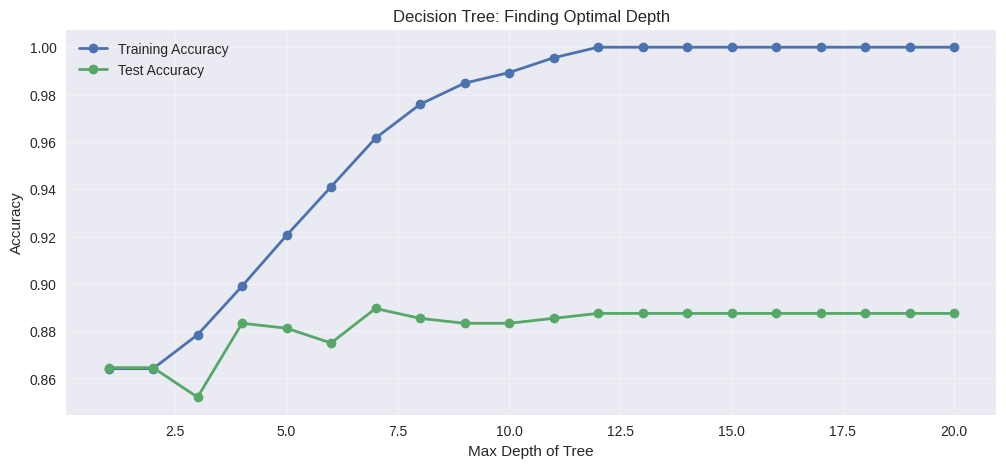

Оптимальная глубина: 7 (accuracy: 0.890)

ДЕРЕВО РЕШЕНИЙ - БИНАРНАЯ КЛАССИФИКАЦИЯ - РЕЗУЛЬТАТЫ:
Accuracy: 0.890
Precision: 0.630
Recall: 0.446
F1-Score: 0.523


In [8]:
print("ДЕРЕВО РЕШЕНИЙ - БИНАРНАЯ КЛАССИФИКАЦИЯ:")
print("="*50)

depth_range = range(1, 21)
train_scores_dt = []
test_scores_dt = []

for depth in depth_range:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train_b, y_train_b)

    train_score = dt.score(X_train_b, y_train_b)
    test_score = dt.score(X_test_b, y_test_b)

    train_scores_dt.append(train_score)
    test_scores_dt.append(test_score)

plt.figure(figsize=(12, 5))
plt.plot(depth_range, train_scores_dt, 'o-', label='Training Accuracy', linewidth=2)
plt.plot(depth_range, test_scores_dt, 'o-', label='Test Accuracy', linewidth=2)
plt.xlabel('Max Depth of Tree')
plt.ylabel('Accuracy')
plt.title('Decision Tree: Finding Optimal Depth')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

optimal_depth = test_scores_dt.index(max(test_scores_dt)) + 1
print(f"Оптимальная глубина: {optimal_depth} (accuracy: {max(test_scores_dt):.3f})")

dt_binary = DecisionTreeClassifier(max_depth=optimal_depth, random_state=42)
dt_binary.fit(X_train_b, y_train_b)

y_pred_dt_b = dt_binary.predict(X_test_b)
y_pred_proba_dt_b = dt_binary.predict_proba(X_test_b)[:, 1]

print("\nДЕРЕВО РЕШЕНИЙ - БИНАРНАЯ КЛАССИФИКАЦИЯ - РЕЗУЛЬТАТЫ:")
print(f"Accuracy: {accuracy_score(y_test_b, y_pred_dt_b):.3f}")
print(f"Precision: {precision_score(y_test_b, y_pred_dt_b):.3f}")
print(f"Recall: {recall_score(y_test_b, y_pred_dt_b):.3f}")
print(f"F1-Score: {f1_score(y_test_b, y_pred_dt_b):.3f}")

ДЕРЕВО РЕШЕНИЙ - МНОГОКЛАССОВАЯ КЛАССИФИКАЦИЯ:
Лучшие параметры: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Лучшая точность: 0.822

ДЕРЕВО РЕШЕНИЙ - МНОГОКЛАССОВАЯ КЛАССИФИКАЦИЯ - РЕЗУЛЬТАТЫ:
Accuracy: 0.838

Classification Report:
              precision    recall  f1-score   support

        High       0.68      0.29      0.41        65
         Low       0.17      0.05      0.08        19
      Medium       0.86      0.96      0.91       396

    accuracy                           0.84       480
   macro avg       0.57      0.44      0.47       480
weighted avg       0.81      0.84      0.81       480



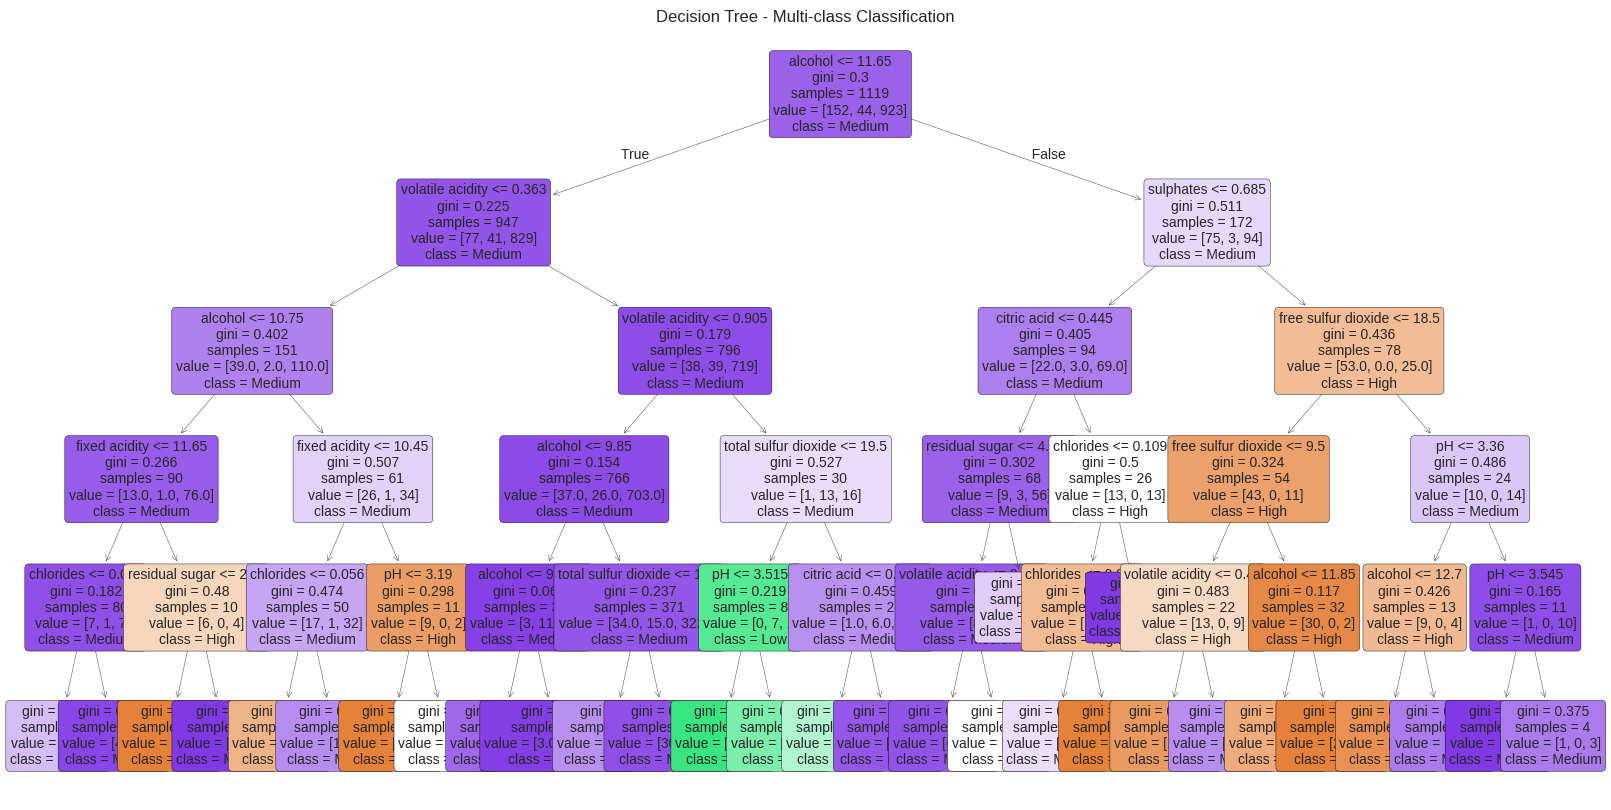

In [9]:
print("ДЕРЕВО РЕШЕНИЙ - МНОГОКЛАССОВАЯ КЛАССИФИКАЦИЯ:")
print("="*50)

dt_multi = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(dt_multi, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_m, y_train_m)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая точность: {grid_search.best_score_:.3f}")

dt_multi_best = grid_search.best_estimator_
y_pred_dt_m = dt_multi_best.predict(X_test_m)

print("\nДЕРЕВО РЕШЕНИЙ - МНОГОКЛАССОВАЯ КЛАССИФИКАЦИЯ - РЕЗУЛЬТАТЫ:")
print(f"Accuracy: {accuracy_score(y_test_m, y_pred_dt_m):.3f}")
print("\nClassification Report:")
print(classification_report(y_test_m, y_pred_dt_m))

plt.figure(figsize=(20, 10))
plot_tree(dt_multi_best,
          feature_names=features,
          class_names=dt_multi_best.classes_,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Decision Tree - Multi-class Classification')
plt.show()

СРАВНЕНИЕ МОДЕЛЕЙ - БИНАРНАЯ КЛАССИФИКАЦИЯ:
СРАВНИТЕЛЬНАЯ ТАБЛИЦА МЕТРИК:
           Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0            KNN      0.90      0.793   0.354     0.489    0.808
1  Decision Tree      0.89      0.630   0.446     0.523    0.805


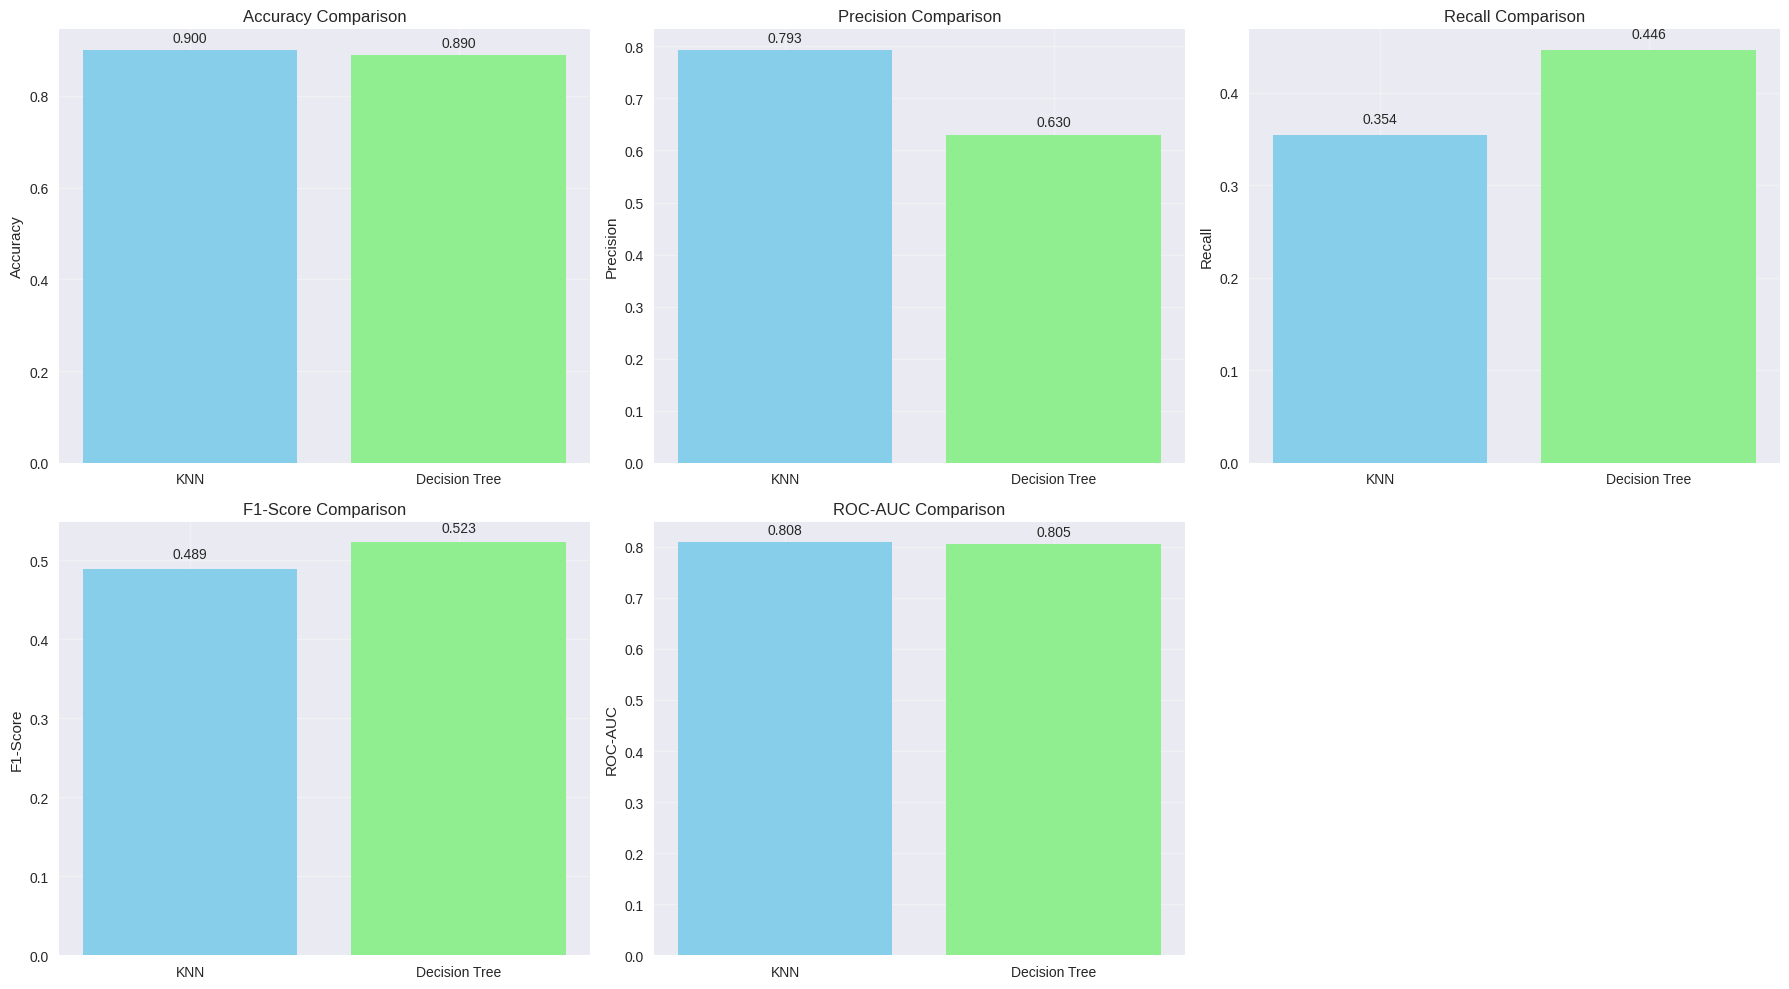

In [10]:
print("СРАВНЕНИЕ МОДЕЛЕЙ - БИНАРНАЯ КЛАССИФИКАЦИЯ:")
print("="*50)

binary_results = []

models_binary = {
    'KNN': (y_pred_knn_b, y_pred_proba_knn_b),
    'Decision Tree': (y_pred_dt_b, y_pred_proba_dt_b)
}

for model_name, (y_pred, y_pred_proba) in models_binary.items():
    accuracy = accuracy_score(y_test_b, y_pred)
    precision = precision_score(y_test_b, y_pred)
    recall = recall_score(y_test_b, y_pred)
    f1 = f1_score(y_test_b, y_pred)
    roc_auc = roc_auc_score(y_test_b, y_pred_proba)

    binary_results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

binary_df = pd.DataFrame(binary_results)
print("СРАВНИТЕЛЬНАЯ ТАБЛИЦА МЕТРИК:")
print(binary_df.round(3))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, metric in enumerate(metrics_to_plot):
    axes[i].bar(binary_df['Model'], binary_df[metric], color=['skyblue', 'lightgreen'])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].grid(True, alpha=0.3)

    for j, v in enumerate(binary_df[metric]):
        axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

if len(metrics_to_plot) < 6:
    for i in range(len(metrics_to_plot), 6):
        axes[i].set_visible(False)

plt.tight_layout()
plt.show()

ROC-КРИВЫЕ И МАТРИЦЫ ОШИБОК:


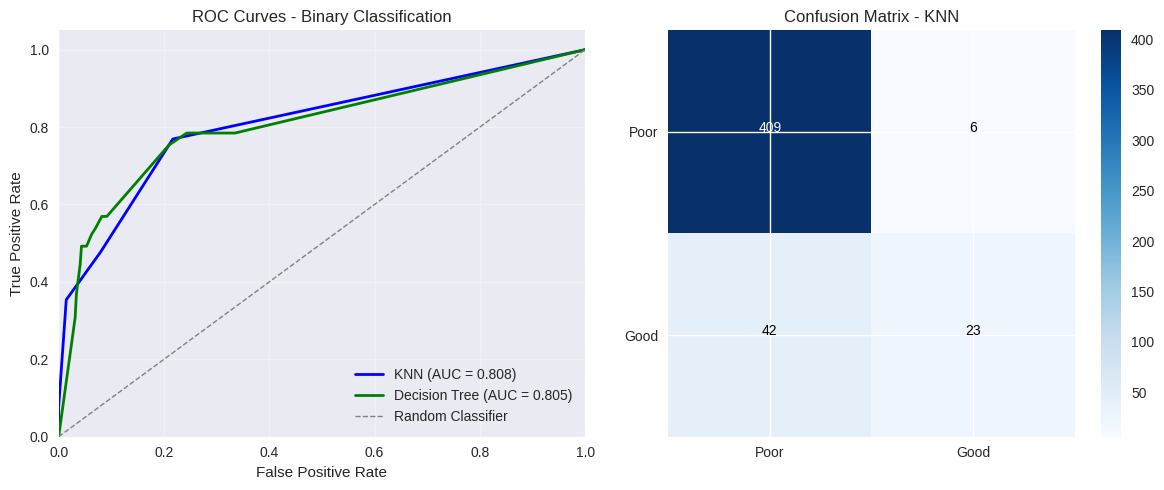

МАТРИЦЫ ОШИБОК:
KNN Confusion Matrix:
[[409   6]
 [ 42  23]]

Decision Tree Confusion Matrix:
[[398  17]
 [ 36  29]]


In [11]:
print("ROC-КРИВЫЕ И МАТРИЦЫ ОШИБОК:")
print("="*50)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
fpr_knn, tpr_knn, _ = roc_curve(y_test_b, y_pred_proba_knn_b)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_dt, tpr_dt, _ = roc_curve(y_test_b, y_pred_proba_dt_b)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'KNN (AUC = {roc_auc_knn:.3f})')
plt.plot(fpr_dt, tpr_dt, color='green', lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Binary Classification')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
cm_knn = confusion_matrix(y_test_b, y_pred_knn_b)
cm_dt = confusion_matrix(y_test_b, y_pred_dt_b)

plt.imshow(cm_knn, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - KNN')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Poor', 'Good'])
plt.yticks(tick_marks, ['Poor', 'Good'])

thresh = cm_knn.max() / 2.
for i, j in np.ndindex(cm_knn.shape):
    plt.text(j, i, format(cm_knn[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_knn[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

print("МАТРИЦЫ ОШИБОК:")
print("KNN Confusion Matrix:")
print(cm_knn)
print("\nDecision Tree Confusion Matrix:")
print(cm_dt)

СРАВНЕНИЕ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ:
СРАВНИТЕЛЬНАЯ ТАБЛИЦА МЕТРИК:
           Model  Accuracy  Precision  Recall  F1-Score
0            KNN     0.848      0.834   0.848     0.840
1  Decision Tree     0.838      0.805   0.838     0.807


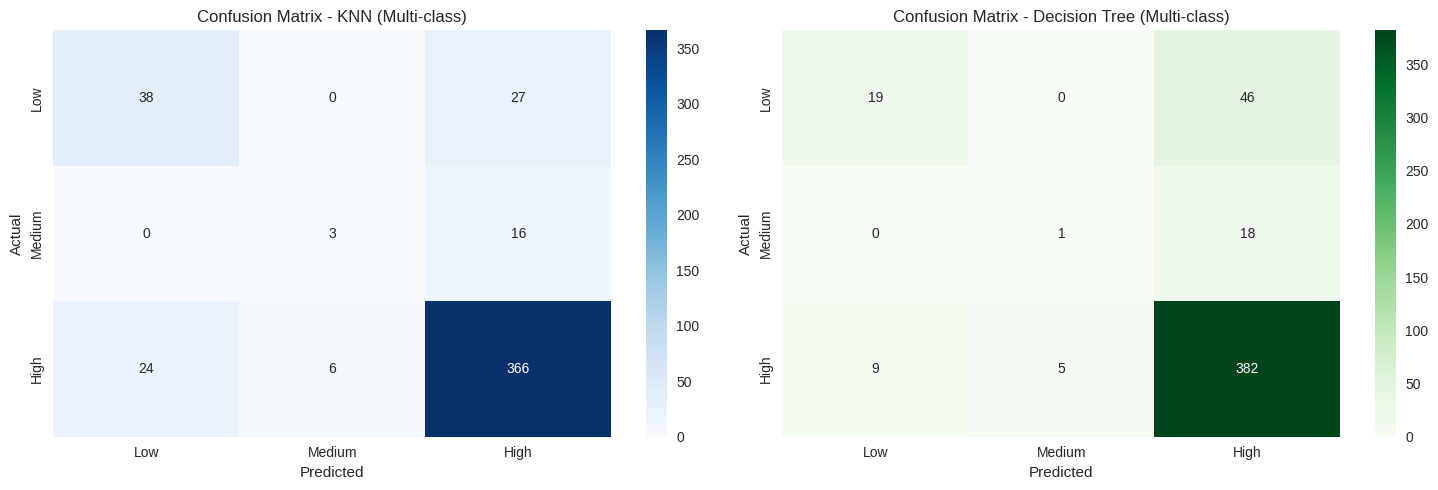

In [12]:
print("СРАВНЕНИЕ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ:")
print("="*50)

multi_results = []

models_multi = {
    'KNN': y_pred_knn_m,
    'Decision Tree': y_pred_dt_m
}

for model_name, y_pred in models_multi.items():
    accuracy = accuracy_score(y_test_m, y_pred)
    precision = precision_score(y_test_m, y_pred, average='weighted')
    recall = recall_score(y_test_m, y_pred, average='weighted')
    f1 = f1_score(y_test_m, y_pred, average='weighted')

    multi_results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

multi_df = pd.DataFrame(multi_results)
print("СРАВНИТЕЛЬНАЯ ТАБЛИЦА МЕТРИК:")
print(multi_df.round(3))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

cm_knn_multi = confusion_matrix(y_test_m, y_pred_knn_m)
sns.heatmap(cm_knn_multi, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'], ax=ax1)
ax1.set_title('Confusion Matrix - KNN (Multi-class)')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

cm_dt_multi = confusion_matrix(y_test_m, y_pred_dt_m)
sns.heatmap(cm_dt_multi, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'], ax=ax2)
ax2.set_title('Confusion Matrix - Decision Tree (Multi-class)')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

КРОСС-ВАЛИДАЦИЯ ДЛЯ ПРОВЕРКИ УСТОЙЧИВОСТИ МОДЕЛЕЙ:
БИНАРНАЯ КЛАССИФИКАЦИЯ (5-fold CV):
KNN CV Scores: [0.88392857 0.85267857 0.83482143 0.88392857 0.87443946]
KNN Mean CV Accuracy: 0.866 (+/- 0.039)
Decision Tree CV Scores: [0.86160714 0.83482143 0.83482143 0.88839286 0.8206278 ]
Decision Tree Mean CV Accuracy: 0.848 (+/- 0.048)


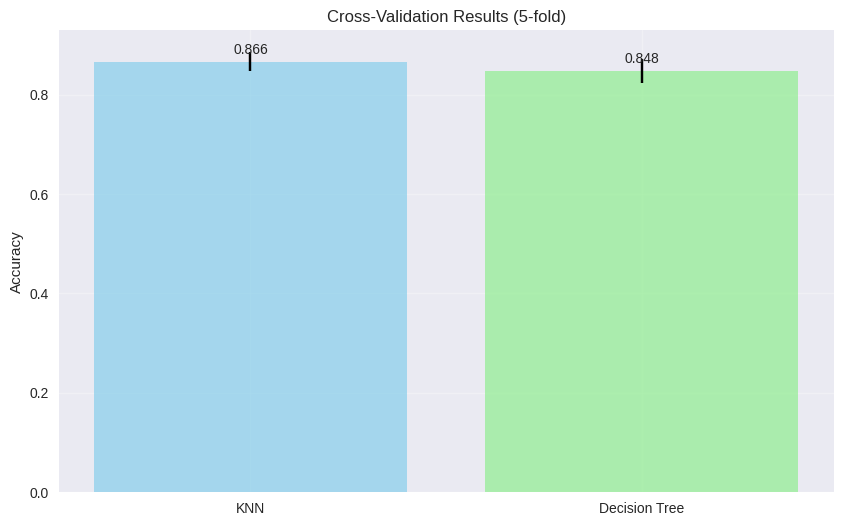

In [13]:
print("КРОСС-ВАЛИДАЦИЯ ДЛЯ ПРОВЕРКИ УСТОЙЧИВОСТИ МОДЕЛЕЙ:")
print("="*50)

print("БИНАРНАЯ КЛАССИФИКАЦИЯ (5-fold CV):")

knn_cv_scores = cross_val_score(knn_binary, X_train_b_scaled, y_train_b, cv=5, scoring='accuracy')
dt_cv_scores = cross_val_score(dt_binary, X_train_b, y_train_b, cv=5, scoring='accuracy')

print(f"KNN CV Scores: {knn_cv_scores}")
print(f"KNN Mean CV Accuracy: {knn_cv_scores.mean():.3f} (+/- {knn_cv_scores.std() * 2:.3f})")

print(f"Decision Tree CV Scores: {dt_cv_scores}")
print(f"Decision Tree Mean CV Accuracy: {dt_cv_scores.mean():.3f} (+/- {dt_cv_scores.std() * 2:.3f})")

plt.figure(figsize=(10, 6))
models_cv = ['KNN', 'Decision Tree']
cv_means = [knn_cv_scores.mean(), dt_cv_scores.mean()]
cv_stds = [knn_cv_scores.std(), dt_cv_scores.std()]

bars = plt.bar(models_cv, cv_means, yerr=cv_stds, capsize=10,
               color=['skyblue', 'lightgreen'], alpha=0.7)
plt.ylabel('Accuracy')
plt.title('Cross-Validation Results (5-fold)')
plt.grid(True, alpha=0.3)

for bar, mean in zip(bars, cv_means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{mean:.3f}', ha='center', va='bottom')

plt.show()

АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ:
ВАЖНОСТЬ ПРИЗНАКОВ (Decision Tree):
                 Feature  Importance
10               alcohol    0.232150
6   total sulfur dioxide    0.121829
9              sulphates    0.118909
1       volatile acidity    0.101384
7                density    0.080336
3         residual sugar    0.078750
4              chlorides    0.067067
8                     pH    0.058644
5    free sulfur dioxide    0.053137
2            citric acid    0.046721
0          fixed acidity    0.041072


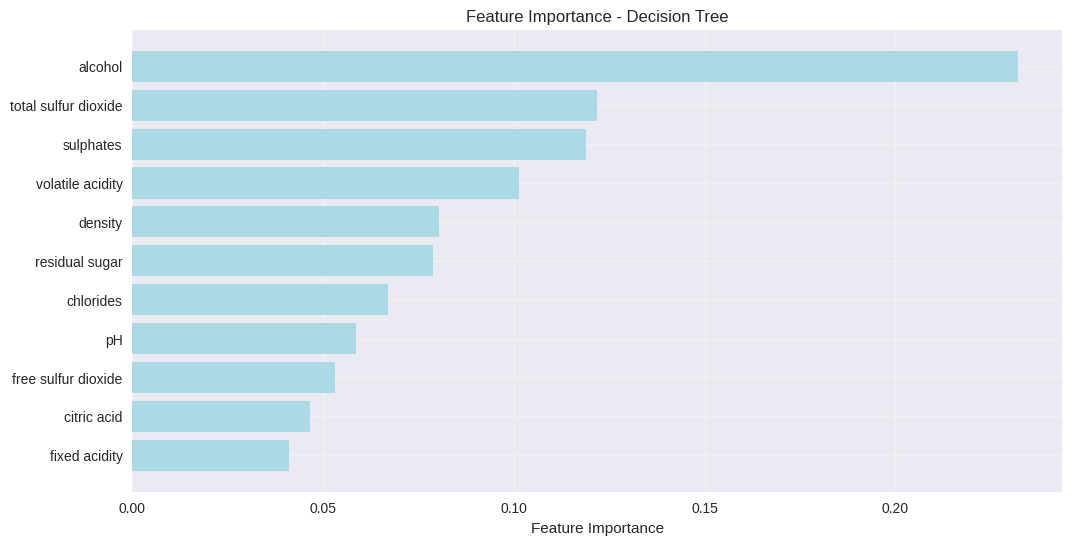


КОРРЕЛЯЦИЯ ПРИЗНАКОВ С КАЧЕСТВОМ ВИНА:
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64


In [14]:
print("АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ:")
print("="*50)

feature_importance = dt_binary.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("ВАЖНОСТЬ ПРИЗНАКОВ (Decision Tree):")
print(feature_importance_df)

plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='lightblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Decision Tree')
plt.grid(True, alpha=0.3)
plt.gca().invert_yaxis()
plt.show()

correlation_with_target = df[features + ['quality']].corr()['quality'].sort_values(ascending=False)
print("\nКОРРЕЛЯЦИЯ ПРИЗНАКОВ С КАЧЕСТВОМ ВИНА:")
print(correlation_with_target[1:])

In [15]:
print("ИТОГОВЫЕ ВЫВОДЫ И СРАВНЕНИЕ АЛГОРИТМОВ:")
print("="*60)

conclusions = f"""
 ИТОГОВЫЙ АНАЛИЗ КЛАССИФИКАЦИИ:

1. РЕЗУЛЬТАТЫ БИНАРНОЙ КЛАССИФИКАЦИИ (Хорошее/Плохое вино):
   • KNN:
     - Accuracy: {binary_df[binary_df['Model']=='KNN']['Accuracy'].values[0]:.3f}
     - Precision: {binary_df[binary_df['Model']=='KNN']['Precision'].values[0]:.3f}
     - Recall: {binary_df[binary_df['Model']=='KNN']['Recall'].values[0]:.3f}
     - F1-Score: {binary_df[binary_df['Model']=='KNN']['F1-Score'].values[0]:.3f}
     - ROC-AUC: {binary_df[binary_df['Model']=='KNN']['ROC-AUC'].values[0]:.3f}

   • Decision Tree:
     - Accuracy: {binary_df[binary_df['Model']=='Decision Tree']['Accuracy'].values[0]:.3f}
     - Precision: {binary_df[binary_df['Model']=='Decision Tree']['Precision'].values[0]:.3f}
     - Recall: {binary_df[binary_df['Model']=='Decision Tree']['Recall'].values[0]:.3f}
     - F1-Score: {binary_df[binary_df['Model']=='Decision Tree']['F1-Score'].values[0]:.3f}
     - ROC-AUC: {binary_df[binary_df['Model']=='Decision Tree']['ROC-AUC'].values[0]:.3f}

2. РЕЗУЛЬТАТЫ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ (Низкое/Среднее/Высокое качество):
   • KNN: Accuracy = {multi_df[multi_df['Model']=='KNN']['Accuracy'].values[0]:.3f}
   • Decision Tree: Accuracy = {multi_df[multi_df['Model']=='Decision Tree']['Accuracy'].values[0]:.3f}

3. КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:
   • Наиболее важные признаки: alcohol, volatile acidity, sulphates
   • Decision Tree показывает лучшую интерпретируемость
   • KNN требует масштабирования данных
   • Оба алгоритма страдают от несбалансированности классов

4. РЕКОМЕНДАЦИИ:
   • Для данного набора данных Decision Tree показывает стабильно хорошие результаты
   • KNN эффективен при правильном подборе параметров
   • Для улучшения результатов可以考虑 методы борьбы с несбалансированностью
   • Alcohol является наиболее значимым предиктором качества вина

5. ВЫБОР ЛУЧШЕЙ МОДЕЛИ:
   • Бинарная классификация: {'KNN' if binary_df[binary_df['Model']=='KNN']['Accuracy'].values[0] > binary_df[binary_df['Model']=='Decision Tree']['Accuracy'].values[0] else 'Decision Tree'}
   • Многоклассовая классификация: {'KNN' if multi_df[multi_df['Model']=='KNN']['Accuracy'].values[0] > multi_df[multi_df['Model']=='Decision Tree']['Accuracy'].values[0] else 'Decision Tree'}

ДАТА ВЫПОЛНЕНИЯ: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}
"""

print(conclusions)

results_summary = {
    'binary_classification': binary_df,
    'multi_classification': multi_df,
    'feature_importance': feature_importance_df,
    'best_binary_model': 'KNN' if binary_df[binary_df['Model']=='KNN']['Accuracy'].values[0] > binary_df[binary_df['Model']=='Decision Tree']['Accuracy'].values[0] else 'Decision Tree',
    'best_multi_model': 'KNN' if multi_df[multi_df['Model']=='KNN']['Accuracy'].values[0] > multi_df[multi_df['Model']=='Decision Tree']['Accuracy'].values[0] else 'Decision Tree'
}

print("Результаты сохранены для отчета")

ИТОГОВЫЕ ВЫВОДЫ И СРАВНЕНИЕ АЛГОРИТМОВ:

 ИТОГОВЫЙ АНАЛИЗ КЛАССИФИКАЦИИ:

1. РЕЗУЛЬТАТЫ БИНАРНОЙ КЛАССИФИКАЦИИ (Хорошее/Плохое вино):
   • KNN:
     - Accuracy: 0.900
     - Precision: 0.793
     - Recall: 0.354
     - F1-Score: 0.489
     - ROC-AUC: 0.808

   • Decision Tree:
     - Accuracy: 0.890
     - Precision: 0.630
     - Recall: 0.446
     - F1-Score: 0.523
     - ROC-AUC: 0.805

2. РЕЗУЛЬТАТЫ МНОГОКЛАССОВОЙ КЛАССИФИКАЦИИ (Низкое/Среднее/Высокое качество):
   • KNN: Accuracy = 0.848
   • Decision Tree: Accuracy = 0.838

3. КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:
   • Наиболее важные признаки: alcohol, volatile acidity, sulphates
   • Decision Tree показывает лучшую интерпретируемость
   • KNN требует масштабирования данных
   • Оба алгоритма страдают от несбалансированности классов

4. РЕКОМЕНДАЦИИ:
   • Для данного набора данных Decision Tree показывает стабильно хорошие результаты
   • KNN эффективен при правильном подборе параметров
   • Для улучшения результатов可以考虑 методы борьбы с несбаланс

In [16]:
print("АНАЛИЗ ВЛИЯНИЯ НЕСБАЛАНСИРОВАННОСТИ КЛАССОВ:")
print("="*50)

from sklearn.utils import resample

print("МЕТРИКИ ДЛЯ КЛАССА 'ХОРОШЕЕ ВИНО' (меньшинственный класс):")
print(f"Precision (KNN): {precision_score(y_test_b, y_pred_knn_b):.3f}")
print(f"Recall (KNN): {recall_score(y_test_b, y_pred_knn_b):.3f}")
print(f"Precision (Decision Tree): {precision_score(y_test_b, y_pred_dt_b):.3f}")
print(f"Recall (Decision Tree): {recall_score(y_test_b, y_pred_dt_b):.3f}")

print("\nРЕКОМЕНДАЦИИ ПО УЛУЧШЕНИЮ:")
print("• Применение техник обработки несбалансированных данных:")
print("  - Oversampling (SMOTE)")
print("  - Undersampling")
print("  - Использование весов классов")
print("  - Изменение порога классификации")

dt_balanced = DecisionTreeClassifier(
    max_depth=optimal_depth,
    random_state=42,
    class_weight='balanced'
)
dt_balanced.fit(X_train_b, y_train_b)
y_pred_balanced = dt_balanced.predict(X_test_b)

print(f"\nDecision Tree с балансировкой весов:")
print(f"Accuracy: {accuracy_score(y_test_b, y_pred_balanced):.3f}")
print(f"Precision: {precision_score(y_test_b, y_pred_balanced):.3f}")
print(f"Recall: {recall_score(y_test_b, y_pred_balanced):.3f}")
print(f"F1-Score: {f1_score(y_test_b, y_pred_balanced):.3f}")

АНАЛИЗ ВЛИЯНИЯ НЕСБАЛАНСИРОВАННОСТИ КЛАССОВ:
МЕТРИКИ ДЛЯ КЛАССА 'ХОРОШЕЕ ВИНО' (меньшинственный класс):
Precision (KNN): 0.793
Recall (KNN): 0.354
Precision (Decision Tree): 0.630
Recall (Decision Tree): 0.446

РЕКОМЕНДАЦИИ ПО УЛУЧШЕНИЮ:
• Применение техник обработки несбалансированных данных:
  - Oversampling (SMOTE)
  - Undersampling
  - Использование весов классов
  - Изменение порога классификации

Decision Tree с балансировкой весов:
Accuracy: 0.838
Precision: 0.440
Recall: 0.738
F1-Score: 0.552
